In [ ]:
import pandas as pd

# Load the training dataset
train_file_path = '/content/train.csv'
train_data = pd.read_csv(train_file_path)

# Load the testing dataset
test_file_path = '/content/test.csv'
test_data = pd.read_csv(test_file_path)

# Display the first few rows of the training dataset to understand its structure
print("Training Dataset Head:")
print(train_data.head())

# Display the first few rows of the testing dataset to understand its structure
print("\nTesting Dataset Head:")
print(test_data.head())

Training Dataset Head:
   ID  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   1         1         0         1         0         1         0         1   
1   2         0         0         0         0         0         0         0   
2   3         1         1         1         1         1         1         1   
3   4         0         0         0         0         0         0         0   
4   5         0         0         0         0         0         0         0   

   A8_Score  A9_Score  ...  gender       ethnicity jaundice austim  \
0         0         1  ...       f               ?       no     no   
1         0         0  ...       m               ?       no     no   
2         1         1  ...       m  White-European       no    yes   
3         0         0  ...       f               ?       no     no   
4         0         0  ...       m               ?       no     no   

   contry_of_res used_app_before     result     age_desc  relation Class/ASD  
0 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming the A1_Score to A9_Score are the features for prediction
features_columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score']

# Selecting features and target from the training data
X_train = train_data[features_columns]
y_train = train_data['Class/ASD']

# Since we're dealing with categorical scores (0 or 1), standardization might not be necessary for tree-based models,
# but it's a good practice for general ML model compatibility.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Splitting the training data to evaluate the model later (if needed)
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Preparing the test dataset similarly
X_test = test_data[features_columns]
X_test_scaled = scaler.transform(X_test)  # Using the same scaler to ensure consistency

# The datasets are now ready for model training and prediction

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense

def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder, encoder

# Assuming 9 ASD assessment scores as input features
autoencoder, encoder = build_autoencoder(X_train_part.shape[1])

# Train the autoencoder
history = autoencoder.fit(X_train_part, X_train_part,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_val_part, X_val_part))

Epoch 1/50
3/3 [==============================] - 3s 91ms/step - loss: 0.7216 - val_loss: 0.6901
Epoch 2/50
3/3 [==============================] - 0s 14ms/step - loss: 0.6771 - val_loss: 0.6509
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 0.6383 - val_loss: 0.6133
Epoch 4/50
3/3 [==============================] - 0s 15ms/step - loss: 0.5997 - val_loss: 0.5744
Epoch 5/50
3/3 [==============================] - 0s 18ms/step - loss: 0.5587 - val_loss: 0.5319
Epoch 6/50
3/3 [==============================] - 0s 15ms/step - loss: 0.5126 - val_loss: 0.4826
Epoch 7/50
3/3 [==============================] - 0s 14ms/step - loss: 0.4601 - val_loss: 0.4248
Epoch 8/50
3/3 [==============================] - 0s 14ms/step - loss: 0.3976 - val_loss: 0.3550
Epoch 9/50
3/3 [==============================] - 0s 14ms/step - loss: 0.3232 - val_loss: 0.2731
Epoch 10/50
3/3 [==============================] - 0s 14ms/step - loss: 0.2345 - val_loss: 0.1776
Epoch 11/50
3/3 [============

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Transform the features using the encoder
X_train_encoded = encoder.predict(X_train_part)
X_val_encoded = encoder.predict(X_val_part)

# Augment original features with encoded features
X_train_augmented = np.concatenate((X_train_part, X_train_encoded), axis=1)
X_val_augmented = np.concatenate((X_val_part, X_val_encoded), axis=1)

# Train a Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_augmented, y_train_part)

# Train a simple Neural Network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_augmented.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_augmented, y_train_part, epochs=50, batch_size=64, validation_data=(X_val_augmented, y_val_part))

gb_predictions_proba = gb_model.predict_proba(X_val_augmented)[:, 1]
nn_predictions_proba = nn_model.predict(X_val_augmented).flatten()


5/5 [==============================] - 0s 2ms/step
Epoch 1/50
10/10 [==============================] - 1s 25ms/step - loss: 1.6171 - accuracy: 0.5437 - val_loss: 0.3503 - val_accuracy: 0.8250
Epoch 2/50
10/10 [==============================] - 0s 8ms/step - loss: 0.3365 - accuracy: 0.8125 - val_loss: 0.3494 - val_accuracy: 0.8250
Epoch 3/50
10/10 [==============================] - 0s 6ms/step - loss: 0.3252 - accuracy: 0.8391 - val_loss: 0.3505 - val_accuracy: 0.8375
Epoch 4/50
10/10 [==============================] - 0s 6ms/step - loss: 0.3199 - accuracy: 0.8453 - val_loss: 0.3410 - val_accuracy: 0.8500
Epoch 5/50
10/10 [==============================] - 0s 6ms/step - loss: 0.3126 - accuracy: 0.8484 - val_loss: 0.3322 - val_accuracy: 0.8562
Epoch 6/50
10/10 [==============================] - 0s 7ms/step - loss: 0.3100 - accuracy: 0.8438 - val_loss: 0.3353 - val_accuracy: 0.8562
Epoch 7/50
10/10 [==============================] - 0s 6ms/step - loss: 0.3025 - accuracy: 0.8516 - val_loss

In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions with both models
gb_predictions = gb_model.predict(X_val_augmented)
nn_predictions = nn_model.predict(X_val_augmented).flatten()
nn_predictions = np.where(nn_predictions > 0.5, 1, 0)

# Combine predictions by averaging
combined_predictions = (gb_predictions + nn_predictions) / 2
final_predictions = np.round(combined_predictions).astype(int)

# Evaluate final predictions
final_accuracy = accuracy_score(y_val_part, final_predictions)
print(f'Final Accuracy: {final_accuracy}')

5/5 [==============================] - 0s 4ms/step
Final Accuracy: 0.88125


predictions


In [ ]:
# Transform the test features using the trained encoder
X_test_encoded = encoder.predict(X_test_scaled)

# Augment the original test features with the encoded features
X_test_augmented = np.concatenate((X_test_scaled, X_test_encoded), axis=1)

7/7 [==============================] - 0s 9ms/step


In [ ]:
# Make predictions with the gradient boosting model
gb_test_predictions = gb_model.predict(X_test_augmented)

# Make predictions with the neural network
nn_test_predictions = nn_model.predict(X_test_augmented).flatten()
nn_test_predictions = np.where(nn_test_predictions > 0.5, 1, 0)

7/7 [==============================] - 0s 2ms/step


In [ ]:
# Combine predictions by averaging and round them to get the final class
combined_test_predictions = (gb_test_predictions + nn_test_predictions) / 2
final_test_predictions = np.round(combined_test_predictions).astype(int)

In [ ]:
# Assuming you want to see the predictions or save them to a CSV
test_predictions_output = pd.DataFrame({'ID': test_data['ID'],'Gender': test_data['gender'],'Austim': test_data['austim'], 'Predicted_Class/ASD': final_test_predictions})
print(test_predictions_output.head())  # Display the first few predictions

# Optionally, save the predictions to a CSV file
output_file_path = '/content/finial.csv'
test_predictions_output.to_csv(output_file_path, index=False)

   ID Gender Austim  Predicted_Class/ASD
0   1      m     no                    0
1   2      m     no                    0
2   3      m     no                    0
3   4      m     no                    0
4   5      m     no                    0


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

# Assuming X_train_scaled is your preprocessed feature set and y_train is the target
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Perform cross-validation and print out the accuracy for each fold
cv_scores = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Gradient Boosting CV scores:", cv_scores)
print("Average CV score:", cv_scores.mean())

Gradient Boosting CV scores: [0.8     0.85    0.85    0.85625 0.85   ]
Average CV score: 0.8412499999999999


In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []

for train, test in kfold.split(X_train_scaled, y_train):
    # Create the model
    model = Sequential()
    model.add(Dense(12, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model
    model.fit(X_train_scaled[train], y_train[train], epochs=50, batch_size=10, verbose=0)

    # Evaluate the model
    scores = model.evaluate(X_train_scaled[test], y_train[test], verbose=0)
    print(f"Neural Network {model.metrics_names[1]}: {scores[1]*100}")
    cvscores.append(scores[1] * 100)

print(f"Neural Network Average CV Score: {np.mean(cvscores)}")

Neural Network accuracy: 85.6249988079071
Neural Network accuracy: 82.4999988079071
Neural Network accuracy: 85.00000238418579
Neural Network accuracy: 85.6249988079071
Neural Network accuracy: 84.375
Neural Network Average CV Score: 84.62499976158142


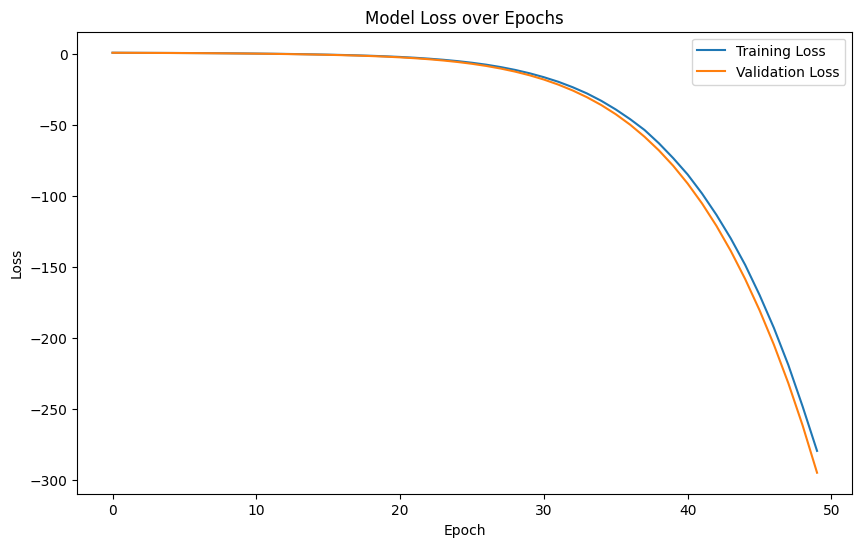

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:

# Import the required functions from sklearn.metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming gb_predictions, nn_predictions, and final_predictions are already defined
# and y_val_part is your validation set true labels

# For Gradient Boosting model
gb_precision = precision_score(y_val_part, gb_predictions)
gb_recall = recall_score(y_val_part, gb_predictions)
gb_f1 = f1_score(y_val_part, gb_predictions)

print(f"Gradient Boosting Precision: {gb_precision}")
print(f"Gradient Boosting Recall: {gb_recall}")
print(f"Gradient Boosting F1 Score: {gb_f1}")

# For Neural Network model
nn_precision = precision_score(y_val_part, nn_predictions)
nn_recall = recall_score(y_val_part, nn_predictions)
nn_f1 = f1_score(y_val_part, nn_predictions)

print(f"Neural Network Precision: {nn_precision}")
print(f"Neural Network Recall: {nn_recall}")
print(f"Neural Network F1 Score: {nn_f1}")

# For combined predictions
combined_precision = precision_score(y_val_part, final_predictions)
combined_recall = recall_score(y_val_part, final_predictions)
combined_f1 = f1_score(y_val_part, final_predictions)

print(f"Combined Model Precision: {combined_precision}")
print(f"Combined Model Recall: {combined_recall}")
print(f"Combined Model F1 Score: {combined_f1}")

Gradient Boosting Precision: 0.7419354838709677
Gradient Boosting Recall: 0.6388888888888888
Gradient Boosting F1 Score: 0.6865671641791045
Neural Network Precision: 0.75
Neural Network Recall: 0.5833333333333334
Neural Network F1 Score: 0.6562499999999999
Combined Model Precision: 0.84
Combined Model Recall: 0.5833333333333334
Combined Model F1 Score: 0.6885245901639344


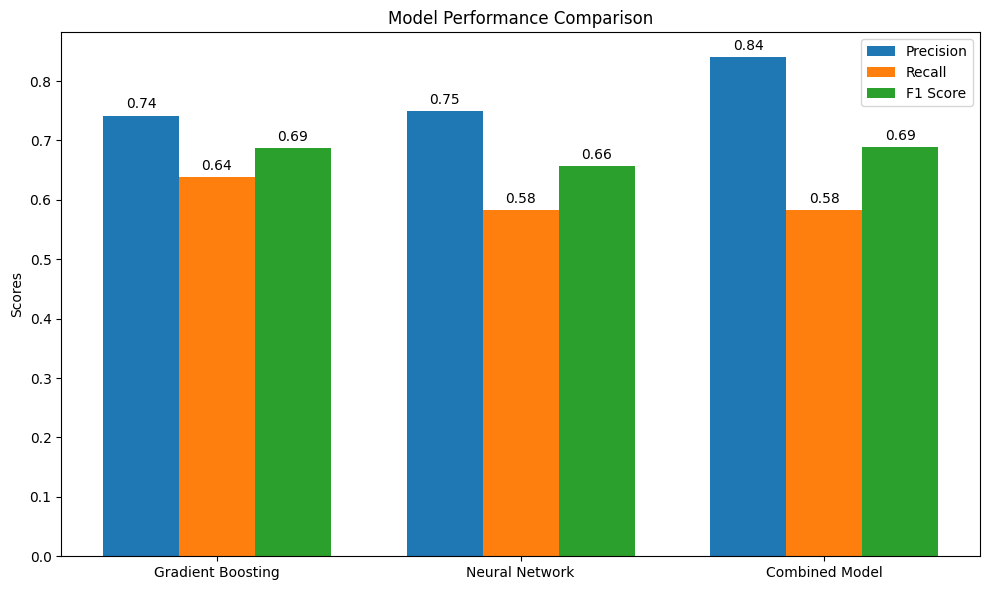

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Labels for the groups
labels = ['Gradient Boosting', 'Neural Network', 'Combined Model']

# Metrics data
precision_scores = [gb_precision, nn_precision, combined_precision]
recall_scores = [gb_recall, nn_recall, combined_recall]
f1_scores = [gb_f1, nn_f1, combined_f1]

# Setting the positions and width for the bars
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision_scores, width, label='Precision')
rects2 = ax.bar(x, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width, f1_scores, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


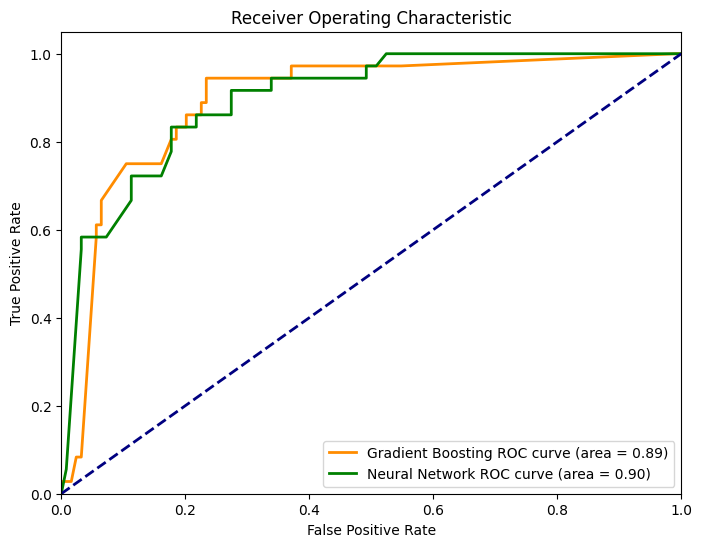

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Now, these variables are defined with the model predictions
fpr_gb, tpr_gb, _ = roc_curve(y_val_part, gb_predictions_proba)
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_nn, tpr_nn, _ = roc_curve(y_val_part, nn_predictions_proba)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='Gradient Boosting ROC curve (area = %0.2f)' % roc_auc_gb)
plt.plot(fpr_nn, tpr_nn, color='green', lw=2, label='Neural Network ROC curve (area = %0.2f)' % roc_auc_nn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()